# Model Explainability for Image Classification

In production ML, it’s not enough to just predict labels — stakeholders often want to **understand why a model makes certain predictions**:

- Developers can debug unexpected behavior  
- Business users can gain trust in the model  
- Ethical AI and regulatory requirements may demand interpretability  

This notebook introduces **explainability for image classification** using **Grad-CAM**, a technique that highlights which parts of an image contributed most to the model’s prediction.  

You will learn how to:

1. Load a trained model (or train a lightweight one locally).  
2. Load and preprocess images from TFDS.  
3. Generate predictions in-memory.  
4. Visualize Grad-CAM heatmaps to interpret model decisions.  

By the end of this notebook, you will be able to **explain model predictions visually**, an important step for production-ready computer vision systems.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Load or Train Model

IMG_SIZE = 224
MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    IMG_SIZE = model.input_shape[1]
    print(f"Model expects: {model.input_shape}")
else:
    print("Saved model not found. Training lightweight model for demo...")
    (ds_train, ds_val), ds_info = tfds.load(
        "tf_flowers",
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    NUM_CLASSES = ds_info.features["label"].num_classes

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    def preprocess(image, label):
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image / 255.0
        return image, label
    
    ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_train, epochs=1)
    
    # Save for reuse
    os.makedirs("saved_model", exist_ok=True)
    model.save(MODEL_PATH)


Loaded saved model.
Model expects: (None, 224, 224, 3)


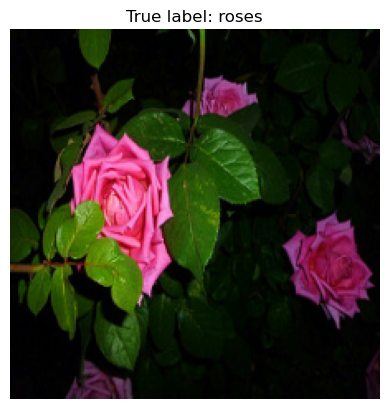

In [2]:
# Load Validation Dataset and Select a Sample Image

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

CLASS_NAMES = ds_info.features["label"].names

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess_image).batch(1)

for image, label in ds_val.take(1):
    sample_image = image.numpy()[0]
    sample_label = label.numpy()[0]
    plt.imshow(sample_image)
    plt.title(f"True label: {CLASS_NAMES[sample_label]}")
    plt.axis("off")
    plt.show()
    break


In [3]:
# Generate Prediction

pred_probs = model.predict(np.expand_dims(sample_image, axis=0))
pred_label = np.argmax(pred_probs, axis=1)[0]
print(f"Model Prediction: {CLASS_NAMES[pred_label]}")


1/1 [==============================] - 1s 772ms/step
Model Prediction: roses


Detected nested base model: mobilenetv2_1.00_224
Using last conv layer: Conv_1


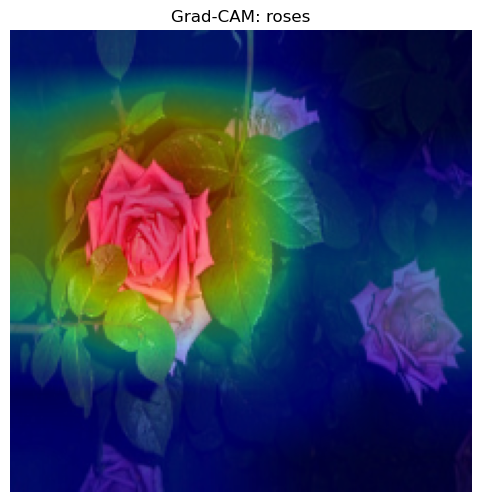

In [4]:
# Grad-CAM Explainability

input_tensor = tf.expand_dims(sample_image, axis=0)

# Detect architecture type

if isinstance(model.layers[0], tf.keras.Model):
    # Nested model (e.g., MobileNetV2)
    base_model = model.layers[0]
    classifier_layers = model.layers[1:]
    print("Detected nested base model:", base_model.name)
else:
    # Flat CNN model
    base_model = model
    classifier_layers = []
    print("Detected flat model architecture")

# Find last Conv2D layer

last_conv_layer = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break

if last_conv_layer is None:
    raise ValueError("No Conv2D layer found.")

print("Using last conv layer:", last_conv_layer.name)

# Build model up to last conv layer

conv_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=last_conv_layer.output
)

# Forward pass + gradients

with tf.GradientTape() as tape:

    conv_outputs = conv_model(input_tensor)

    # Continue forward pass through remaining base layers
    x = conv_outputs
    for layer in base_model.layers[base_model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)

    # Then through classifier layers (if any)
    for layer in classifier_layers:
        x = layer(x)

    predictions = x
    pred_label = tf.argmax(predictions[0])
    loss = predictions[:, pred_label]

# Compute gradients

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap = tf.image.resize(heatmap[..., tf.newaxis], (IMG_SIZE, IMG_SIZE))
heatmap = tf.squeeze(heatmap).numpy()

# Overlay

pred_label = int(pred_label)

plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title(f"Grad-CAM: {CLASS_NAMES[pred_label]}")
plt.axis("off")
plt.show()



## Notes
- Grad-CAM shows which regions of the image the model focused on when making a prediction.
- Explainability is critical for debugging, trust, and fairness in production computer vision pipelines.
- You can extend this to multiple images, batches, or integrate with TFLite models for edge explainability.